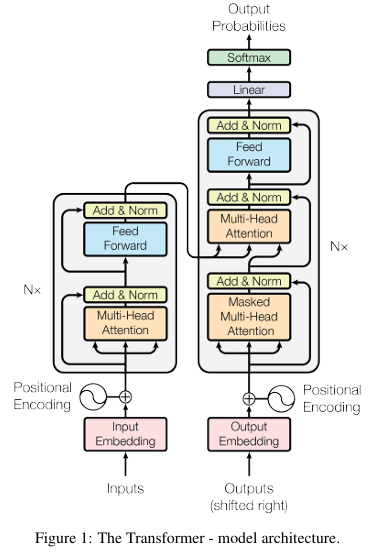

In [2]:
import torch
import torch.nn as nn
import math


In [13]:
class Embedding(nn.Module):
    
    def __init__(self, vocab_size, embed_dim):
        super(Embedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, x):
        embedding_vector =  self.embedding(x)
        return embedding_vector

In [27]:
## Testing Embedding:
embedding_layer = nn.Embedding(2,6)
input = torch.ones(2,5)
embedding_layer.weight.shape


RuntimeError: Could not infer dtype of builtin_function_or_method

In [24]:
embed_out = embedding_layer(torch.tensor([1,0,1,1,0]))
embed_out

tensor([[ 0.6689, -0.1138, -0.5161, -0.1730, -1.9346, -0.4015],
        [ 1.5976,  0.9680, -0.2084,  0.4755,  0.8034,  0.5365],
        [ 0.6689, -0.1138, -0.5161, -0.1730, -1.9346, -0.4015],
        [ 0.6689, -0.1138, -0.5161, -0.1730, -1.9346, -0.4015],
        [ 1.5976,  0.9680, -0.2084,  0.4755,  0.8034,  0.5365]],
       grad_fn=<EmbeddingBackward0>)

In [4]:
print(torch.__version__)

2.3.1+cu118


In [9]:
pe = torch.zeros(5,3)
pe

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [10]:
class PositionalEmbedding(nn.Module):

    def __init__(self, seq_len, embed_dim):
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_dim
        
        pe = torch.zeros(seq_len, self.embed_dim) # 2d tensor
        for pos in range (seq_len):
            for i in range(self.embed_dim,2):
                pe[pos, i] = math.sin( pos / (10000 ** ((2*i)/self.embed_dim)))
                pe[pos, i+1] = math.cos(pos / (10000 ** ((2*i)/self.embed_dim)))
        
        pe = pe.unsqueeze(0) # 3d tensor
        self.register_buffer('pe', pe) #for loading state dict

    
    def forward(self, x):
        return x+ self.pe[:, x.size(1)]



## Self Attention
Steps:
1) Create Q, K, V vector for each token from the sequence. Each vector will be of same dim as of input embedding.
Also, consider multihead attentions.
- How to create them?
By mutmul with matrix Qw, Kw and Vw which acts as the weight and they are learnt during the training process.
So, approximate it with linear layer(basically, it is also matmul) Note: to make bias = False.

2) Calculate the attention score
- How?
By multiplying Q and K. (dot product of Q and K)

3) Divide the above attention score by sacling factor of sqaure root of key dimension (for now, all 3 vector have same dim)

4) Multiply the scaled attention score with value matrix (V).

5) Combine all the value from each head and pass through linear layer. To get final (z)

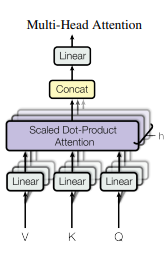
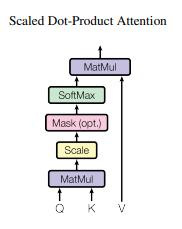

## Building Multihead Attention

##### Implementaiton can be done in either of these two ways:
1) By splitting the Qw, Kw, Vw matrix into same number as number of self attention heads. -> Original Paper Idea
- MultiHead(Q, K, V ) = Concat(head1, ..., headh)Wo
- where headi = Attention(QWi , KWi , VWi )
2) Taking just one Qw, Kw, and Vw matrix. But spliting the intermediate output into same number as number of heads and then calculating in separate heads.
- Eventual goal is to create Q, K, V vectors equal to the number of heads.



In [7]:
# 1st approach
class MultiHeadAttention(nn.Module):

    def __init__(self, embed_dim, n_heads):
        """
        Args: embed_dim = dimension of each embedding vector
        n_head = number of self attention heads
        """

        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.single_head_dim = int(self.embed_dim / self.n_heads)  ## better to create assertion in case of not exactly divisible.
        # If embed_dim = 512 and n_head= 8, then single_head_dim = 64

        # all query, key and value matrixes are : 64 x 64 (Thus 1st approach)-> Mentioned in orginal paper 
        self.query_matrix = nn.Linear(self.single_head_dim, self.single_head_dim ,bias = False)
        self.key_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias = False)
        self.value_matrix = nn.Linear(self.single_head_dim, self.single_head_dim, bias= False)
        
        # out_matrix is to project the concatenated vector to single same dim embedding vector. so 64*8 --> 512
        self.out_matrix = nn.Linear(self.n_heads * self.single_head_dim, self.embed_dim)

    def forward(self, query, key, value, mask = None):
        # Normally each embedding in passed in the form of batch. So,
        # batch_size X sequence length X embedding dimension.

        batch_size = key.size(0)
        seq_length = key.size(1)

        # Query dimension can be changed in the decoder side during inference. so we can't take general seq_length.
        seq_length_query = query.size(1)

        # Changing the dim (splitting in dimensions as the number of heads) To make it multihead.
        # 32 X 10 X 512 -> 32 X 10 X 8 X 64
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim)
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim)

        q = self.query_matrix(query)  # 32 X 10 X 8 X 64
        k = self.key_matrix(key)
        v = self.value_matrix(value)

        # Transposing into (batch_size, n_heads, seq_length, single_head_dim)
        q = q.transpose(1,2) # 32 X 8 X 10 X 64
        k = k.transpose(1,2) # 32 X 8 X 10 X 64
        v = v.transpose(1,2) # 32 X 8 X 10 X 64

        ## Making second matrix's dim suitable for matrix multiplication. (q.kT)
        k_adjusted =  k.transpose(-2, -1)  # (batch_size, n_heads, single_head_dim, seq_length)

        ## Calculation of attention scores:
        # Can use "@"  for matmul in pytorch
        product = (torch.matmul(q, k_adjusted))/math.sqrt(self.single_head_dim) #(batch_size, n_heads, seq_length, seq_length)
        if mask is not None:
            product = product.masked_fill(mask == 0, float("-1e20"))

        attention_socres = product.softmax(product)
        attention =  torch.matmul(attention_socres, v) ## (batch_size, n_heads, seq_length, single_head_dim)

        ## Combining multiheads:
        concat = attention.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.embed_dim)
        output = self.out(concat) #(32, 10, 512) => (32, 10, 512)

        return output

## Encoder Section:
Steps:
1) Passing inpu(padded tokens corresponding to the sentence) through embedding and positional embedding layer.
    Input(batch_size X seq_length) -> Output (batch_size X seq_length X embedding_layer)
2) Passed through multihead attention to create good representation of each words.
    Input(batch_size X seq_length, embedding_layer) -> Output (batch_size X seq_length, embedding_layer)
3) Add and Normalization
4) Feed Forward
5) Add and Normalization

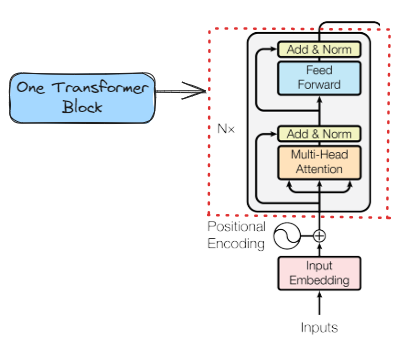

### Defining one transformer block:
1 transformer block is made up of :
- multihead attention
- normalization1
- Position-wise feed forward (same as simple feed forward??)
    - According to d2l, it is known as a “position-wise” network because it “transforms the representation at all the sequence positions using the same MLP.”
- normalization2

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, n_heads, expansion_factor):
        super(TransformerBlock, self).__init__()
        self.linear1_expand = expansion_factor * embed_dim
        
        self.multihead_attention = MultiHeadAttention(embed_dim, n_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, self.linear1_expand),
            nn.ReLU(),
            nn.Linear(self.linear1_expand, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self, query, key, value):

        attention_out = self.multihead_attention(query, key, value)
        attention_residual_out = attention_out + value
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) # batch_size, seq_length, embed_dim

        feedfwd_out = self.feed_forward(norm1_out)
        feedfwd_residual_out = feedfwd_out + norm1_out
        norm2_out = self.dropout2(self.norm2(feedfwd_residual_out)) # batch_size, seq_length, embed_dim

        return norm2_out

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self,seq_length, vocab_size, embed_dim, n_heads, expansion_factor,num_layers) :
        super(TransformerEncoder, self).__init__()

        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_length, embed_dim)

        # stacking multiple transformer layers: Nx = 6 (In original paper)
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, n_heads, expansion_factor) for _ in range(num_layers)])

    def forward(self, x):
        '''
        x : 
        '''
        embed_out = self.positional_encoder(self.embedding_layer(x))
        out = embed_out ##Input and output to transformer encoder for each layers.

        for layer in self.layers:
            out = layer(out, out, out) # query, key, value

        return out